# Baseline Soybean Classification using a MLP

In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from PIL import Image
from PIL import ImageFilter
from keras import initializers
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)

Using TensorFlow backend.


## File Paths

In [2]:
train_dir = "TrainData/"
train_ann = "TrainAnnotations.csv"
test_dir = "TestData/"

In [34]:
def load_data():
    """
    Load the image training data and classes
    :return: list of numpy arrays, list of integer labels, list of string filenames (for reference)
    """
    file_labels = pd.read_csv(train_ann)
    ann_dict = pd.Series(file_labels.annotation.values, index=file_labels.file_name).to_dict()
    image_dict = dict.fromkeys(ann_dict.keys())
    print("Loading image data into dictionary...")
    for filename in list(ann_dict.keys()):
        image_dict[filename] = np.array(Image.open(train_dir + filename))
    print("Loading complete.")
    print("Preparing training data...")
    data = []
    labels = []
    names = []
    for filename in list(ann_dict):
        data.append(image_dict[filename])
        labels.append(ann_dict[filename])
        names.append(filename)
    print("Preparation complete.")
    return data, labels, names

X, y, filenames = load_data()


Loading image data into dictionary...
Loading complete.
Preparing training data...
Preparation complete.


## Visualize the Data

In [4]:
def visualize_data(array):
    """
    Plot a given numpy array
    :param array: a numpy array (image)
    """
    if len(array.shape) == 3:  # has all 3 RGB channels
        plt.imshow(array)
    else:  # just a black and white image (one channel)
        plt.imshow(array, cmap='gray')
    plt.axis("off")
    plt.show()

## Feature Extraction Functions

In [5]:
def edge_filter(array, f_type="canny"):
    """
    Detect the edges within an image using a chosen filter
    :param array: a numpy array (image)
    :param f_type: the filter type in ['canny', 'laplacian', 'sobelx', 'sobely']
    :return: a numpy array (edge image)
    """
    edges = None
    if f_type == 'canny':
        edges = cv2.Canny(array, 120, 200)
    elif f_type == 'laplacian':
        # convert to grayscale --- one channel
        # Sobel filter in both directions
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Laplacian(array, cv2.CV_64F, ksize=5))
    elif f_type == "sobelx":
        # convert to grayscale --- one channel
        # get vertical edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 1, 0, ksize=5))
    elif f_type == "sobely":
        # convert to grayscale --- one channel
        # get horizontal edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 0, 1, ksize=5))
    return edges

def extract_channel(array, channel='green'):
    """
    Extract one channel from the image (default green because that is arguably the most important
    for this application)
    :param array: a numpy array (image)
    :param channel: string in ('red', 'green', 'blue')
    :return: a numpy array (image, one channel)
    """
    channel_dict = {'red': 0, 'green': 1, 'blue': 2}
    matrix = array[:, :, channel_dict[channel]]
    return matrix

def extract_sift(array):
    """
    Get the SIFT features from an image
    :param array: a numpy array (image)
    :return: key points, image of the key points
    """
    sift = cv2.xfeatures2d.SIFT_create(1000)
    key_points = sift.detect(array, None)
    image = cv2.drawKeypoints(array, key_points, np.array([]), (0, 0, 255),
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return key_points, image

def extract_pil_edges(array):
    """
    Get the edges from an image
    :param array: a numpy array (image)
    :return: a numpy array (edge map)
    """
    im = Image.fromarray(array)
    edge = im.filter(ImageFilter.FIND_EDGES)
    return np.array(edge)

def extract_pil_emboss(array):
    """
    Get the embossed version of an image
    :param array: a numpy array (image)config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
    :return: a numpy array (embossed)
    """
    im = Image.fromarray(array)
    emboss = im.filter(ImageFilter.EMBOSS)
    return np.array(emboss)

def extract_hog(array, visualize=False):
    """
    Get the Histogram of Gradients of the image
    :param array: a numpy array (image)
    :param visualize: to visualize the HOG image or not [True, False]
    :return: HOG vector (for training), HOG image (for visualization)
    """
    if visualize:
        vector, im = hog(array,
                         orientations=8,
                         pixels_per_cell=(4, 4),
                         cells_per_block=(1, 1),
                         block_norm='L2-Hys',
                         feature_vector=True,
                         visualize=True)
        return vector, im
    else:
        vector = hog(array,
                     orientations=8,
                     pixels_per_cell=(4, 4),
                     cells_per_block=(1, 1),
                     feature_vector=True,
                     block_norm='L2-Hys')
        return vector

def extract_grayscale(array):
    """
    Converts an image to grayscale
    """
    im = Image.fromarray(array)
    return np.array(im.convert('L'))

## Features

In [6]:
print("Extracting features...")
# lists of non-flattened numpy arrays
hogs = []
greens = []
edges = []
sifts = []
embosses = []# for visualization only
for i in range(len(X)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X))
    hogs.append(extract_hog(X[i], visualize=False))
    greens.append(extract_channel(X[i], channel="green"))
    edges.append(extract_pil_edges(X[i]))
    embosses.append(extract_pil_emboss(X[i]))
    # the image, purely for visualization of those key points
print("Feature Extraction Complete.")

Extracting features...
Preprocessing Image 1 / 1025
Preprocessing Image 11 / 1025
Preprocessing Image 21 / 1025
Preprocessing Image 31 / 1025
Preprocessing Image 41 / 1025
Preprocessing Image 51 / 1025
Preprocessing Image 61 / 1025
Preprocessing Image 71 / 1025
Preprocessing Image 81 / 1025
Preprocessing Image 91 / 1025
Preprocessing Image 101 / 1025
Preprocessing Image 111 / 1025
Preprocessing Image 121 / 1025
Preprocessing Image 131 / 1025
Preprocessing Image 141 / 1025
Preprocessing Image 151 / 1025
Preprocessing Image 161 / 1025
Preprocessing Image 171 / 1025
Preprocessing Image 181 / 1025
Preprocessing Image 191 / 1025
Preprocessing Image 201 / 1025
Preprocessing Image 211 / 1025
Preprocessing Image 221 / 1025
Preprocessing Image 231 / 1025
Preprocessing Image 241 / 1025
Preprocessing Image 251 / 1025
Preprocessing Image 261 / 1025
Preprocessing Image 271 / 1025
Preprocessing Image 281 / 1025
Preprocessing Image 291 / 1025
Preprocessing Image 301 / 1025
Preprocessing Image 311 / 1

## Preview Random Image

### Do any visualization you want here before the data is flattened in the next section

Previewing image 016007.jpg from class 3


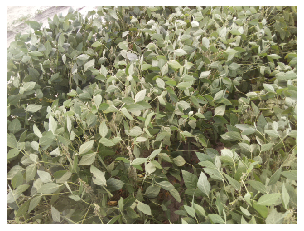

In [7]:
# RGB
index = random.randint(0, len(X) - 1) 
print("Previewing image", filenames[index], "from class", y[index])
visualize_data(X[index])

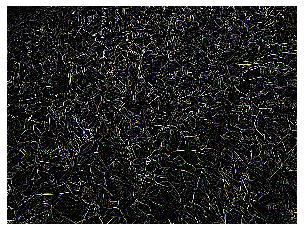

In [8]:
# Edge
visualize_data(edges[index])

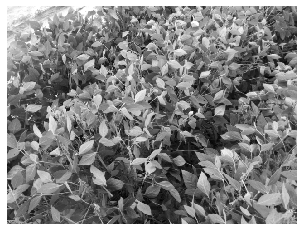

In [9]:
# Green
visualize_data(greens[index])

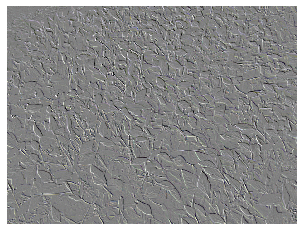

In [10]:
# Emboss
visualize_data(embosses[index])

## Choose Features
### The features with which you'd like to represent each image

In [35]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
for i in range(len(X)):
    X[i] = (extract_grayscale(edges[i]))
print("Building feature representation complete.")

Building training data...
Building feature representation complete.


## Split the Data

In [12]:
def convert_to_tensors(X, y):
    """
    Utility to convert each of the arrays within the train and validation arrays
    to tensors and then convert the containing arrays to tensors
    """
    return tf.convert_to_tensor(list(map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), X)), dtype=tf.float32),\
           tf.convert_to_tensor(list(map(lambda x: tf.convert_to_tensor(x, dtype=tf.int32), y)), dtype=tf.int32)


X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)

X_train, y_train = convert_to_tensors(X_train, y_train)
X_valid, y_valid = convert_to_tensors(X_valid, y_valid)

# Normalize data
X_train, X_valid = tf.realdiv(X_train, 255.0), tf.realdiv(X_valid, 255.0)

print("Splitting complete.")

Vector size: (480, 640)
Splitting the data...
Splitting complete.


## Hyperparameter Optimization
Using `scikit-optimize`, the dimensions of the hyperparameter search space are defined and 
explored to find hyperparameters that maximizes validation accuracy. For this model, the
following hyperparameter are explored:

* neurons (number of neurons in the hidden layer of a 2-layer MLP)
* dropout 
* epochs
* batch size 

In [14]:
# Optimization dimensions
num_neurons = Integer(low=32, high=640, name='num_neurons')
dropout_rate = Real(low=0.2, high=0.5, prior='uniform', name='dropout_rate')
epochs = Integer(low=5, high=25, name='epochs')
batch_size = Integer(low=8, high=256, name='batch_size')
dimensions = [num_neurons, dropout_rate, epochs, batch_size]
default_parameters = [314, 0.24055633457480294, 6, 32]

optimization_run_counter = 0

@use_named_args(dimensions=dimensions)
def fitness(num_neurons, dropout_rate, epochs, batch_size):
    """
    Because scikit-optimize gp_minimize minimizes a function, and the principal
    metric here is accuracy, we compute the minimize the inverse of the accuracy
    """
    return 1 / fit_nn(num_neurons, dropout_rate, epochs, batch_size)

def fit_nn(num_neurons, dropout_rate, epochs, batch_size):
    """
    Trains a 2-layer neural network with the specified number of neurons,
    dropout, epochs, and batch size.
    
    This currently assumes an image size of 640x480 with a single color channel.
    """
    global optimization_run_counter
    optimization_run_counter = optimization_run_counter + 1
    print()
    print("Run: {}, hyperparameters: num_neurons={}, dropout_rate={}, epochs={}, batch_size={}".format(optimization_run_counter, num_neurons, dropout_rate, epochs, batch_size))

    model, _ = fit_model(X_train, y_train, X_valid, y_valid, num_neurons, dropout_rate, epochs, batch_size)

    print('Evaluating model...')
    test_results = model.evaluate(X_valid, y_valid, verbose=2)
    
    return test_results[1]

def fit_model(X_train, y_train, X_valid, y_valid, num_neurons, dropout_rate, epochs, batch_size):
    """
    Returns a neural network model fit with the specified training data and hyperparameters.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(480, 640)),
        tf.keras.layers.Dense(num_neurons, activation='relu',
                              kernel_initializer=initializers.random_normal(mean=0, stddev=0.03, seed=1337)),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()

    print('Fitting model...')
    validation_data = None if X_valid is None or y_valid is None else (X_valid, y_valid)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=validation_data)
    
    return model, history


print("Neural Net optimization running...")
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=30,
                            x0=default_parameters,
                            random_state=16)

optimal_neurons = search_result.x[0]
optimal_dropout_rate = search_result.x[1]
optimal_epochs = search_result.x[2]
optimal_batch_size = search_result.x[3]

validation_accuracy = 1 / search_result.fun

print("Best hyperparameters found: neurons={}, dropout={}, epochs={}, batch size={}".format(
    search_result.x[0], search_result.x[1], search_result.x[2], search_result.x[3]))
print("Accuracy:", validation_accuracy)


Neural Net optimization running...

Run: 1, hyperparameters: num_neurons=314, dropout_rate=0.24055633457480294, epochs=6, batch_size=32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 314)               96461114  
_________________________________________________________________
dropout_2 (Dropout)          (None, 314)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1575      
Total params: 96,462,689
Trainable params: 96,462,689
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 820 samples, validate on 205 samples
Epoch 1/6
820/820 [======================

820/820 [==============================] - 3s 3ms/sample - loss: 0.0547 - accuracy: 0.9890 - val_loss: 0.7743 - val_accuracy: 0.7122
Epoch 18/18
820/820 [==============================] - 3s 3ms/sample - loss: 0.0555 - accuracy: 0.9902 - val_loss: 0.6742 - val_accuracy: 0.7463
Evaluating model...
205/205 - 0s - loss: 0.6742 - accuracy: 0.7463

Run: 4, hyperparameters: num_neurons=545, dropout_rate=0.40565649322498154, epochs=8, batch_size=155
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 545)               167424545 
_________________________________________________________________
dropout_5 (Dropout)          (None, 545)               0         
_________________________________________________________________
den

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 272)               83558672  
_________________________________________________________________
dropout_8 (Dropout)          (None, 272)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1365      
Total params: 83,560,037
Trainable params: 83,560,037
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 820 samples, validate on 205 samples
Epoch 1/10
820/820 [==============================] - 6s 7ms/sample - loss: 24.1639 - accuracy: 0.3110 - val_loss: 2.5457 - val_accuracy: 0.2195
Epoch 2/10
820/820 [============

820/820 [==============================] - 2s 2ms/sample - loss: 30.9741 - accuracy: 0.2561 - val_loss: 12.8745 - val_accuracy: 0.4780
Epoch 2/22
820/820 [==============================] - 1s 1ms/sample - loss: 4.9760 - accuracy: 0.3854 - val_loss: 1.5979 - val_accuracy: 0.2293
Epoch 3/22
820/820 [==============================] - 1s 1ms/sample - loss: 1.6028 - accuracy: 0.2232 - val_loss: 1.6084 - val_accuracy: 0.4780
Epoch 4/22
820/820 [==============================] - 1s 1ms/sample - loss: 1.5684 - accuracy: 0.4890 - val_loss: 1.5915 - val_accuracy: 0.4780
Epoch 5/22
820/820 [==============================] - 1s 1ms/sample - loss: 1.4463 - accuracy: 0.4902 - val_loss: 1.3574 - val_accuracy: 0.4780
Epoch 6/22
820/820 [==============================] - 1s 1ms/sample - loss: 1.3314 - accuracy: 0.4878 - val_loss: 1.3588 - val_accuracy: 0.4780
Epoch 7/22
820/820 [==============================] - 1s 1ms/sample - loss: 1.3017 - accuracy: 0.4878 - val_loss: 1.2823 - val_accuracy: 0.4780
E

820/820 [==============================] - 50s 61ms/sample - loss: 0.4041 - accuracy: 0.8598 - val_loss: 2.9614 - val_accuracy: 0.5610
Epoch 14/25
820/820 [==============================] - 50s 60ms/sample - loss: 0.3704 - accuracy: 0.8878 - val_loss: 1.0633 - val_accuracy: 0.6927
Epoch 15/25
820/820 [==============================] - 50s 61ms/sample - loss: 0.5241 - accuracy: 0.8512 - val_loss: 0.9062 - val_accuracy: 0.6049
Epoch 16/25
820/820 [==============================] - 50s 61ms/sample - loss: 0.6027 - accuracy: 0.8134 - val_loss: 1.2290 - val_accuracy: 0.5610
Epoch 17/25
820/820 [==============================] - 50s 61ms/sample - loss: 0.4831 - accuracy: 0.8659 - val_loss: 0.8162 - val_accuracy: 0.6585
Epoch 18/25
820/820 [==============================] - 50s 60ms/sample - loss: 0.4473 - accuracy: 0.8622 - val_loss: 0.7542 - val_accuracy: 0.7171
Epoch 19/25
820/820 [==============================] - 50s 61ms/sample - loss: 0.3496 - accuracy: 0.8805 - val_loss: 1.7657 - val_

Epoch 4/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.6157 - accuracy: 0.7744 - val_loss: 1.0236 - val_accuracy: 0.5854
Epoch 5/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.5688 - accuracy: 0.7890 - val_loss: 0.8252 - val_accuracy: 0.6585
Epoch 6/14
820/820 [==============================] - 46s 57ms/sample - loss: 0.5433 - accuracy: 0.8207 - val_loss: 0.8562 - val_accuracy: 0.7024
Epoch 7/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.4889 - accuracy: 0.8268 - val_loss: 0.8595 - val_accuracy: 0.6732
Epoch 8/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.5364 - accuracy: 0.8024 - val_loss: 0.9104 - val_accuracy: 0.7073
Epoch 9/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.5857 - accuracy: 0.8171 - val_loss: 1.0966 - val_accuracy: 0.5366
Epoch 10/14
820/820 [==============================] - 46s 56ms/sample - loss: 0.4783 - accuracy: 0.7988 - val_loss: 0.7308 

Epoch 6/25
820/820 [==============================] - 2s 3ms/sample - loss: 1.0251 - accuracy: 0.7427 - val_loss: 1.0031 - val_accuracy: 0.6488
Epoch 7/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.4436 - accuracy: 0.8402 - val_loss: 1.0572 - val_accuracy: 0.6049
Epoch 8/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.3662 - accuracy: 0.8500 - val_loss: 1.0181 - val_accuracy: 0.6146
Epoch 9/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.3294 - accuracy: 0.8866 - val_loss: 1.2190 - val_accuracy: 0.6000
Epoch 10/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.2924 - accuracy: 0.8988 - val_loss: 1.3135 - val_accuracy: 0.6244
Epoch 11/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.2005 - accuracy: 0.9390 - val_loss: 0.9917 - val_accuracy: 0.6585
Epoch 12/25
820/820 [==============================] - 2s 3ms/sample - loss: 0.1886 - accuracy: 0.9427 - val_loss: 1.0552 - val_accura

820/820 [==============================] - 61s 74ms/sample - loss: 0.1813 - accuracy: 0.9500 - val_loss: 1.1598 - val_accuracy: 0.6829
Epoch 18/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.2315 - accuracy: 0.9232 - val_loss: 2.9861 - val_accuracy: 0.6098
Epoch 19/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.0712 - accuracy: 0.9756 - val_loss: 1.6197 - val_accuracy: 0.6439
Epoch 20/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.1317 - accuracy: 0.9646 - val_loss: 0.9091 - val_accuracy: 0.7659
Epoch 21/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.1062 - accuracy: 0.9671 - val_loss: 2.2476 - val_accuracy: 0.6293
Epoch 22/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.2214 - accuracy: 0.9537 - val_loss: 3.8896 - val_accuracy: 0.6390
Epoch 23/25
820/820 [==============================] - 61s 74ms/sample - loss: 0.5149 - accuracy: 0.9268 - val_loss: 5.8641 - val_

Epoch 8/10
820/820 [==============================] - 3s 4ms/sample - loss: 0.5844 - accuracy: 0.8061 - val_loss: 1.2694 - val_accuracy: 0.5463
Epoch 9/10
820/820 [==============================] - 3s 4ms/sample - loss: 0.5107 - accuracy: 0.8085 - val_loss: 0.9445 - val_accuracy: 0.6488
Epoch 10/10
820/820 [==============================] - 3s 4ms/sample - loss: 0.3535 - accuracy: 0.8415 - val_loss: 1.0194 - val_accuracy: 0.6000
Evaluating model...
205/205 - 1s - loss: 1.0194 - accuracy: 0.6000

Run: 21, hyperparameters: num_neurons=402, dropout_rate=0.4976670859040449, epochs=16, batch_size=255
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_44 (Dense)             (None, 402)               123494802 
____________________________________________

820/820 [==============================] - 31s 38ms/sample - loss: 24.7466 - accuracy: 0.3902 - val_loss: 3.8993 - val_accuracy: 0.5805
Epoch 2/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.9979 - accuracy: 0.7939 - val_loss: 1.3184 - val_accuracy: 0.5805
Epoch 3/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.2736 - accuracy: 0.9098 - val_loss: 0.7617 - val_accuracy: 0.7220
Epoch 4/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.2148 - accuracy: 0.9305 - val_loss: 0.6886 - val_accuracy: 0.7415
Epoch 5/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.1212 - accuracy: 0.9707 - val_loss: 0.8216 - val_accuracy: 0.7220
Epoch 6/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.0820 - accuracy: 0.9793 - val_loss: 0.8085 - val_accuracy: 0.7171
Epoch 7/24
820/820 [==============================] - 31s 38ms/sample - loss: 0.0785 - accuracy: 0.9780 - val_loss: 1.2669 - val_accur

Evaluating model...
205/205 - 1s - loss: 1.1596 - accuracy: 0.7122

Run: 26, hyperparameters: num_neurons=640, dropout_rate=0.5, epochs=25, batch_size=105
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_54 (Dense)             (None, 640)               196608640 
_________________________________________________________________
dropout_27 (Dropout)         (None, 640)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 3205      
Total params: 196,611,845
Trainable params: 196,611,845
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 820 samples, validate on 205 samples
Epoch 1/25
820/820 

820/820 [==============================] - 8s 10ms/sample - loss: 4.2051 - accuracy: 0.5817 - val_loss: 1.2569 - val_accuracy: 0.5805
Epoch 3/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.8115 - accuracy: 0.6976 - val_loss: 1.1259 - val_accuracy: 0.5756
Epoch 4/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.6845 - accuracy: 0.7232 - val_loss: 0.8557 - val_accuracy: 0.6585
Epoch 5/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.4854 - accuracy: 0.8207 - val_loss: 0.8686 - val_accuracy: 0.6585
Epoch 6/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.3664 - accuracy: 0.8537 - val_loss: 0.8050 - val_accuracy: 0.7171
Epoch 7/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.3206 - accuracy: 0.8817 - val_loss: 0.7876 - val_accuracy: 0.7268
Epoch 8/22
820/820 [==============================] - 8s 10ms/sample - loss: 0.3236 - accuracy: 0.8841 - val_loss: 0.8993 - val_accuracy: 0.6

820/820 [==============================] - 5s 6ms/sample - loss: 65.5099 - accuracy: 0.3024 - val_loss: 28.0201 - val_accuracy: 0.4780
Epoch 2/25
820/820 [==============================] - 4s 5ms/sample - loss: 11.5521 - accuracy: 0.3854 - val_loss: 2.5911 - val_accuracy: 0.5561
Epoch 3/25
820/820 [==============================] - 4s 5ms/sample - loss: 1.6118 - accuracy: 0.5854 - val_loss: 1.2789 - val_accuracy: 0.4732
Epoch 4/25
820/820 [==============================] - 4s 5ms/sample - loss: 0.9679 - accuracy: 0.6268 - val_loss: 1.0885 - val_accuracy: 0.5561
Epoch 5/25
820/820 [==============================] - 4s 5ms/sample - loss: 0.7544 - accuracy: 0.7061 - val_loss: 0.9628 - val_accuracy: 0.6439
Epoch 6/25
820/820 [==============================] - 4s 5ms/sample - loss: 0.6139 - accuracy: 0.7634 - val_loss: 1.0651 - val_accuracy: 0.6049
Epoch 7/25
820/820 [==============================] - 4s 5ms/sample - loss: 0.5119 - accuracy: 0.7805 - val_loss: 0.8319 - val_accuracy: 0.7073


## Train the Model

In [25]:
print("Training the model...")
print("Hyperparameters: neurons={}, dropout={}, epochs={}, batch size={}".format(optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size))
model, history = fit_model(X_train, y_train, X_valid, y_valid, optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size)
print("Training complete.")

Training the model...
Hyperparameters: neurons=569, dropout=0.3505658210938157, epochs=14, batch size=112
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_72 (Dense)             (None, 569)               174797369 
_________________________________________________________________
dropout_36 (Dropout)         (None, 569)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 5)                 2850      
Total params: 174,800,219
Trainable params: 174,800,219
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 820 samples, validate on 205 samples
Epoch 1/14
820/820 [==============================] - 7s 8ms/sample 

## Loss vs Epochs

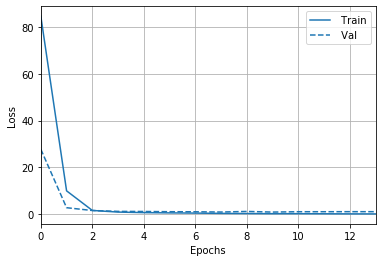

In [26]:
histories = {'': history}
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=None)
plotter.plot(histories)

## Accuracy vs Epochs

(0.1, 0.9)

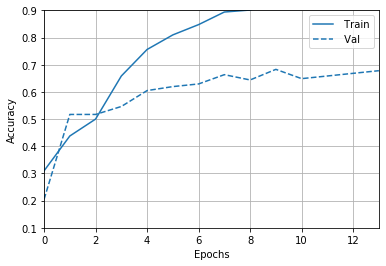

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=None)
plotter.plot(histories)
plt.ylim([0.1, 0.9])

## Validate the Model

In [28]:
# Predict on Validation Set (validation accuracy)
print("Validating the model...")
model.evaluate(X_valid, y_valid, verbose=2)


Validating the model...
205/205 - 1s - loss: 1.0596 - accuracy: 0.6780


[1.0595779418945312, 0.6780488]

## Train the model with all training data

In [ ]:
print("Hyperparameters: neurons={}, dropout={}, epochs={}, batch size={}".format(optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size))

X_tensor, y_tensor = convert_to_tensors(X, y)
model, history = fit_model(X_tensor, y_tensor, None, None, optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size)
print("Training complete.")

Hyperparameters: neurons=569, dropout=0.3505658210938157, epochs=14, batch size=112
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_80 (Dense)             (None, 569)               174797369 
_________________________________________________________________
dropout_40 (Dropout)         (None, 569)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 2850      
Total params: 174,800,219
Trainable params: 174,800,219
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 1025 samples
Epoch 1/14


## Test the model

In [22]:
import os

def load_test_data():
    """
    Load the image test data and classes
    :return: list of numpy arrays, list of filenames
    """
    print("Loading image data...")
    test_image_list = []
    filenames = []
    for filename in list(os.listdir(test_dir)):
        filenames.append(filename)
        test_image_list.append(np.array(Image.open(test_dir + filename)))
    print("Loading complete.")
    return test_image_list, filenames

X_test_data, filenames = load_test_data()

X_test = []

print("Extracting features...")
for i in range(len(X_test)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X_test))
    X_test.append(extract_grayscale(extract_pil_edges(X[i])))
print("Feature Extraction Complete.")

print("Building feature representation complete.")
print("Testing the model...")

y_hat_test = model.predict(X_test)
print("Testing complete.")
one_hots = [np.zeros((5,1)) for pred in y_hat_test]
for i in range(len(one_hots)):
    pred = y_hat_test[i]  # the index of the one-hot encoding
    one_hots[i][pred] = 1
print(len(y_hat_test))
print(len(one_hots))
with open('predictions.csv', 'w') as predictions_file:
    writer = csv.writer(predictions_file, delimiter=',')
    for pred in one_hots:
        writer.writerow(pred.T)


Loading image data...
Loading complete.
Extracting features...
Feature Extraction Complete.
Building feature representation complete.
Testing the model...


AttributeError: 'tuple' object has no attribute 'predict'